In [1]:
import torch
from argparse import Namespace
from ipt.data import get_dataset, get_dataloader
from utils import set_seeds
args = Namespace(batch_size=128, dataset='mnist', seed=0)
args.device = torch.device("cuda:0")
args.channels = 1 if args.dataset == 'mnist' else 3
args.image_size = 224 if args.dataset == 'imagenet' else 32
    
args.patch_size = 2
args.patch_numel = args.channels * args.patch_size**2 
args.num_patches_width = args.image_size // args.patch_size

args.vocab_size = 12
args.eps = 0.3 if args.dataset == 'mnist' else 8/255
args.attack_iters = 100

set_seeds(args.seed)
train_set, test_set = get_dataset(args.dataset)
train_loader, test_loader = get_dataloader(train_set, test_set, args.batch_size)

In [6]:
import torch
import torch.nn as nn
from ipt.networks import DisjointPatchMaker, MLPTokenizer
class IPTNet(nn.Module):
    def __init__(self, args):
        super(IPTNet, self).__init__()
        self.args = args
        self.patcher = DisjointPatchMaker(args)
        self.patch_numel = args.channels * args.patch_size * args.patch_size
        self.tokenizer = MLPTokenizer(args.patch_numel, args.vocab_size, [64, 128])
        self.embedding = nn.Embedding(args.vocab_size, self.patch_numel)
        self.conv1 = nn.Conv2d(args.channels, 64, kernel_size=3, stride=1, padding=1)
        self.softmax = nn.Softmax(-1)
        self.tau = 1

    def forward(self, x):
        patches = self.patcher(x)
        # patches = patches.view(-1, self.patch_numel)
        x = self.tokenizer(patches) # (batch_size, num_patches, vocab_size)
        x = self.softmax(x * self.tau) 
        x = torch.matmul(x, self.embedding.weight) 
        x = self.patcher.inverse(x)
        return x

    def visualize_tok_image(self, img):
        x = self.patcher(img)  # (batch_size, num_patches, patch_numel)
        x = self.tokenizer(x) # (batch_size, num_patches, vocab_size)
        tok_image = x.argmax(2)
        tok_image = tok_image.view(self.args.num_patches_width, self.args.num_patches_width)
        print(tok_image)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.args = args
        self.conv1 = nn.Conv2d(args.channels, 8, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
    
class Dummy(nn.Module):
    def __init__(self, iptnet, classifier):
        super(Dummy, self).__init__()
        self.iptnet = iptnet
        self.classifier = classifier
    
    def forward(self, x):
        x = self.iptnet(x)
        x = self.classifier(x)
        return x

In [13]:
from IPython.display import clear_output, display
from torchvision import transforms
import matplotlib.pyplot as plt
from ipt.attacks import pgd_attack
from tqdm import tqdm
def show_image(image): 
    plt.imshow(transforms.ToPILImage()(image.cpu().detach().squeeze()))
    plt.show()

model = IPTNet(args).to(args.device)
classifier = Classifier().to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
opt_class = torch.optim.Adam(classifier.parameters(), lr=1e-3)

torch.autograd.set_detect_anomaly(True)

for iter_ in range(20):
    for images, labels in tqdm(train_loader, ncols=90, desc='IPT sim training'):
        images = images.to(args.device)
        labels = labels.to(args.device)
        adv_images = pgd_attack(args, images, model, images, True)
        output = model(adv_images)
        mseloss = nn.MSELoss()(output, images)
        optimizer.zero_grad()
        mseloss.backward()
        optimizer.step()
    model.tau *= 1.2
    
    clear_output()
    print(f'Iter: {iter_}, Loss: {mseloss.item()}')
    show_image(adv_images[0:1])
    show_image(output[0:1])
    torch.save(model.cpu().state_dict(), 'ckpt/ipt_mnist.pth')
    model.to(args.device)

    total = correct = 0
    for images, labels in tqdm(train_loader, ncols=90, desc='classifier training'):
        images = images.to(args.device)
        labels = labels.to(args.device)
        output = classifier(model(images))
        loss = nn.CrossEntropyLoss()(output, labels)
        opt_class.zero_grad()
        loss.backward()
        opt_class.step()
        total += labels.size(0)
        correct += (output.argmax(1) == labels).float().mean()
    print("classifier:", correct / total)

    print('== adversarial/sim training ==')
    pbar = tqdm(train_loader, ncols=88, desc='adversarial/sim training')
    dummy = Dummy(model, classifier)
    for images, labels in pbar:
        images, labels = images.to(args.device), labels.to(args.device)
        adv_images = pgd_attack(args, images, dummy, labels, False)
        output = model(adv_images)

        mseloss = nn.MSELoss()(output, images)
        optimizer.zero_grad()
        mseloss.backward(retain_graph=True)
        optimizer.step()

        cl_output = classifier(output.detach())
        cl_loss = nn.CrossEntropyLoss()(cl_output, labels)
        opt_class.zero_grad()
        cl_loss.backward()
        opt_class.step()

        adv_acc = (cl_output.argmax(dim=1) == labels).sum() / len(labels)
        pbar.set_postfix({'acc': float(adv_acc)})
        if pbar.n % (pbar.total//10)==0:
            show_image(adv_images[0:1])
            show_image(output[0:1])



IPT sim training:  44%|██████████████▍                  | 206/469 [02:30<03:12,  1.37it/s]


KeyboardInterrupt: 

In [85]:
model.visualize_tok_image(adv_images[0:1])
print(model.embedding.weight[7])
print(model.embedding.weight[11])

tensor([[ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 11,  7,  7,  5,  7],
        [ 7,  7,  7,  7,  7,  7, 11, 11, 11, 11, 11, 11,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7, 11, 11, 11,  7, 11, 11,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  5, 11, 11, 11,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7, 11, 11,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7,  7, 11, 11,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  5,  7,  7,  7,  7,  7, 11, 11,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7,  7, 11, 11,  7,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7,  7, 11, 11,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7,  7, 11, 11,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 7,  7,  7,  7, 11, 11,  7,  

In [141]:
from ipt.attacks import pgd_attack

def adversarial_training(args, classifier, train_loader):
    classifier.train()
    classifier.to(args.device)
    for param in classifier.iptnet.parameters():
        param.requires_grad = False

    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

    pbar = tqdm(train_loader, ncols=88, desc='adversarial training')
    for images, labels in pbar:
        images, labels = images.to(args.device), labels.to(args.device)
        adv_images = pgd_attack(args, images, classifier, labels)
        output = classifier(adv_images)
        loss = torch.nn.CrossEntropyLoss()(output, labels)
        loss.backward()
        optimizer.step()
        adv_acc = (output.argmax(dim=1) == labels).sum() / len(labels)
        pbar.set_postfix({'acc': float(adv_acc)})

def test_attack(args, model, test_loader, adv_perturb, fast=False):
    total = correct = adv_correct = 0
    model.eval()
    pbar = tqdm(test_loader, ncols=90, desc='test_attack', unit='batch', leave=False)
    for images, labels in pbar:
        images = images.to(args.device)
        labels = labels.to(args.device)
        pred = model(images)
        correct += (pred.argmax(dim=1) == labels).sum()

        adv_images = adv_perturb(args, images, model, labels)
        adv_pred = model(adv_images)
        adv_correct += (adv_pred.argmax(dim=1) == labels).sum()
        total += len(labels)
        if fast and total > 100:
            break
    return correct, adv_correct, total, adv_images


In [132]:
def train_classifier(args, classifier, train_loader):
    classifier.train()
    classifier.to(args.device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    for param in classifier.iptnet.parameters():
        param.requires_grad = False

    cor = tot = 0
    train_pbar = tqdm(train_loader, ncols=88, desc='training classifier')
    for images, labels in train_pbar:

        images = images.to(args.device)
        labels = labels.to(args.device)
        optimizer.zero_grad()
        output = classifier(images)

        loss = torch.nn.CrossEntropyLoss()(output, labels)
        loss.backward()
        optimizer.step()
        cor += (output.argmax(dim=1) == labels).sum()
        tot += len(labels)
        accuracy = float(cor/tot)
        train_pbar.set_postfix(l=f'{float(loss):.4f}', acc=f'{accuracy:.3f}')

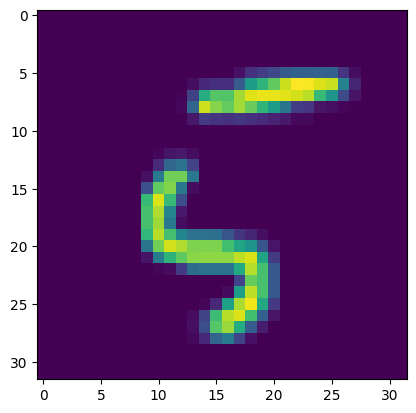

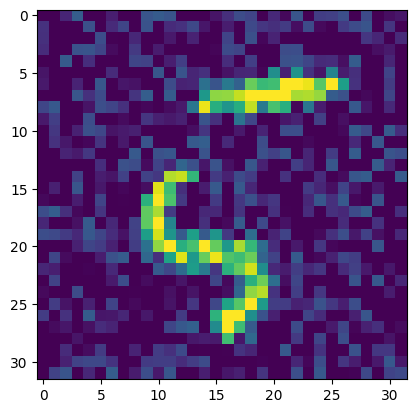

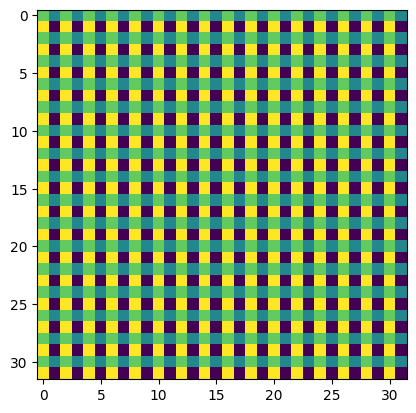

adversarial/sim training:   9%|█            | 40/469 [00:09<01:42,  4.20it/s, acc=0.156]


KeyboardInterrupt: 

In [152]:

classifier = Classifier(model).to(args.device)
for param in classifier.iptnet.parameters():
    param.requires_grad = False
train_classifier(args, classifier, train_loader)
for param in classifier.iptnet.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

pbar = tqdm(train_loader, ncols=88, desc='adversarial/sim training')
for images, labels in pbar:
    images, labels = images.to(args.device), labels.to(args.device)
    adv_images = pgd_attack(args, images, classifier, labels)
    output, sub_output = classifier(adv_images, True)
    # loss = torch.nn.CrossEntropyLoss()(output, labels)
    # loss.backward()
    # output, sub_output = classifier(adv_images, True)
    mseloss = nn.MSELoss()(sub_output, images)
    mseloss.backward()
    optimizer.step()
    adv_acc = (output.argmax(dim=1) == labels).sum() / len(labels)
    pbar.set_postfix({'acc': float(adv_acc)})
    if pbar.n % 10==0:
        clear_output()
        show_image(adv_images[0:1])
        show_image(sub_output[0:1])

## === bin ===

In [ ]:
from ipt.attacks import square_attack, pgd_attack
classifier = Classifier(model).to(args.device)
train_classifier(args, classifier, train_loader)

images, labels = next(iter(test_loader))
images, labels = images.to(args.device), labels.to(args.device)
adv_images = pgd_attack(args, images, classifier, labels)
print((classifier(adv_images).argmax(dim=1) == labels).sum()/len(labels))
show_image(adv_images[0:1])
show_image(classifier.iptnet(adv_images[0:1]))
adv_images = square_attack(args, images, classifier, labels)
print((classifier(adv_images).argmax(dim=1) == labels).sum()/len(labels))
show_image(adv_images[0:1])
show_image(classifier.iptnet(adv_images[0:1]))


7
== pgd attack ==


test acc: 0.0781, adv acc: 0.0781...


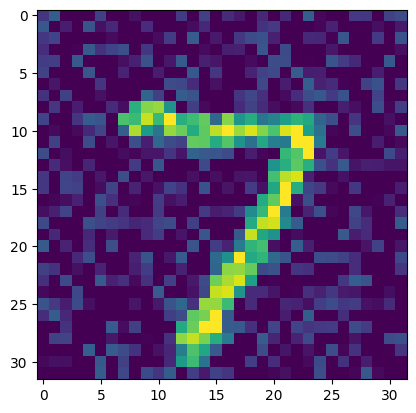

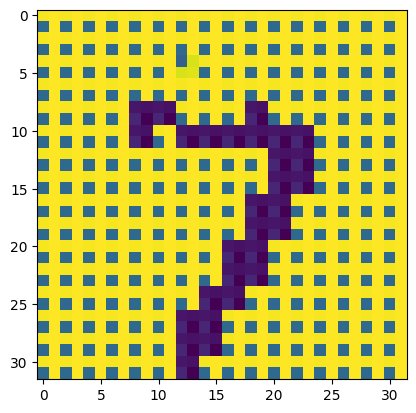

== square attack ==


test acc: 0.0781, adv acc: 0.0547...


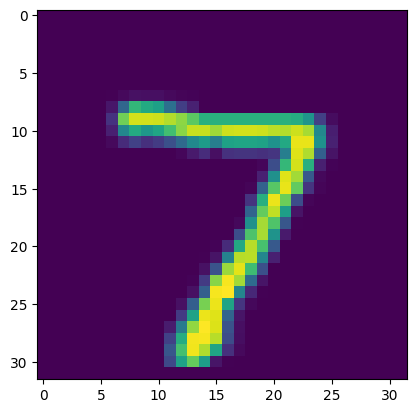

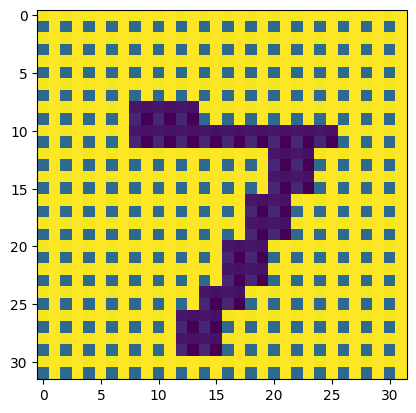

adversarial training:  61%|█████████▏     | 287/469 [00:45<00:28,  6.33it/s, acc=0.0938]


KeyboardInterrupt: 

In [148]:

def clear_and_display(images):
    clear_output()
    for image in images:
        image = transforms.ToPILImage()(image.cpu().detach().squeeze())
        display(image)

from ipt.attacks import square_attack, pgd_attack
for iter_ in range(20):
    adversarial_training(args, classifier, train_loader)
    clear_output()
    print(iter_)
    print('== pgd attack ==')
    correct, adv_correct, total, adv_images = test_attack(args, classifier, test_loader, pgd_attack, True)
    message = f'test acc: {correct/total:.4f}, adv acc: {adv_correct/total:.4f}...'
    print(message)
    show_image(adv_images[0:1])
    show_image(classifier.iptnet(adv_images[0:1]))
    print('== square attack ==')
    correct, adv_correct, total, adv_images = test_attack(args, classifier, test_loader, square_attack, True)
    message = f'test acc: {correct/total:.4f}, adv acc: {adv_correct/total:.4f}...'
    print(message)
    images = []
    show_image(adv_images[0:1])
    show_image(classifier.iptnet(adv_images[0:1]))
